In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import skimage.io as io
import random
import cv2
from torch_geometric.data import Data

ModuleNotFoundError: No module named 'scanpy'

In [2]:
from src.preprocessing.data_process import extract_patches, create_graph_data_dict

In [3]:
def seed_everything(seed=0):
    """Initialize random seeds for reproducibility."""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
# Set random seed for reproducibility
random_seed = 0
seed_everything(random_seed)

# Data Preparation

In [4]:
file_dir = "data/wx_data/"  # Directory containing the data files
files = os.listdir(file_dir)  # List all files in the directory
files = [i for i in files if i.endswith(".h5ad") and "month" in i]  # Filter files to include only those ending with ".h5ad" and containing "month"
file_paths = [os.path.join(file_dir, i) for i in files]  # Create full file paths for the filtered files
adatas = {}  # Initialize an empty dictionary to store AnnData objects

# Read each file and store the AnnData object in the dictionary
for i in range(len(file_paths)):
    adatas[files[i].split(".")[0]] = sc.read(file_paths[i])

# Preprocess each AnnData object
for key in adatas.keys():
    sc.pp.normalize_total(adatas[key], target_sum=1e4)  # Normalize counts per cell
    sc.pp.log1p(adatas[key])  # Logarithmize the data
    sc.pp.scale(adatas[key])  # Scale the data to unit variance

In [5]:
# Extract spatial coordinates for each cell
cell_coords = {}
for key in adatas.keys():
    cell_coords[key] = adatas[key].obsm["spatial"].copy()
    
# Calculate the neighborhood graph
for key in adatas.keys():
    sc.pp.neighbors(adatas[key], n_neighbors=15, use_rep="spatial", random_state=random_seed)
    
# Extract the spatial neighbors
neighbors = {}
for key in adatas.keys():
    neighbors[key] = adatas[key].obsp["connectivities"].copy()

In [6]:

# Load the plaque dataset
img_dir = "data/wx_data/"
img_files = os.listdir(img_dir)
img_files = [i for i in img_files if i.endswith(".tiff") and "plaque" in i]
# Read the images

imgs = {}
for i in range(len(img_files)):
    imgs[img_files[i].split(".")[0]] = io.imread(os.path.join(img_dir, img_files[i]))
imgs.keys()
# Rename the imgs to match the adata keys
for key in list(imgs.keys()):
    parts = key.split("_")
    if len(parts) > 1:
        new_key = parts[1] + "_" + parts[2]
        imgs[new_key] = imgs.pop(key)



In [7]:
# Extract patches from the images
patches = {}
for key in imgs.keys():
    patches[key] = extract_patches(imgs[key], cell_coords[key], patch_size=128)

# Extract the positive patches
positive_patches = {}
for key in patches.keys():
    pos_list = []
    for i in range(len(patches[key])):
        if np.sum(patches[key][i]) > 0:
            pos_list.append(patches[key][i])
    positive_patches[key] = pos_list

# Convert the patches to binary and calculate the area of positive pixels for each patch
binary_patches = {}
for key in patches.keys():
    binary_patches[key] = [patch > 0 for patch in patches[key]]
# Calculate the area of positive pixels for each patch
areas = {}
for key in binary_patches.keys():
    areas[key] = [np.sum(patch) for patch in binary_patches[key]]

Number of patches with different shapes before padding: 0


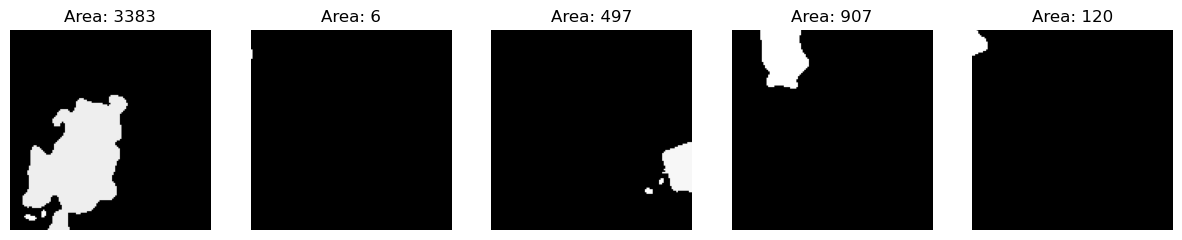

In [8]:
# Choose 5 patches with non-zero area for each image and plot them
import matplotlib.pyplot as plt

# Set the number of patches to plot
n_patches = 5

# Plot the patches
fig, axes = plt.subplots(nrows=len(areas), ncols=n_patches, figsize=(15, 15))
axes = np.atleast_2d(axes)  # Ensure axes is 2D for consistent indexing

for i, key in enumerate(areas.keys()):
    non_zero_indices = np.where(np.array(areas[key]) > 0)[0]
    chosen_indices = random.sample(list(non_zero_indices), n_patches)
    for j, idx in enumerate(chosen_indices):
        axes[i, j].imshow(patches[key][idx], cmap="gray")
        axes[i, j].set_title(f"Area: {areas[key][idx]}")
        axes[i, j].axis("off")
    axes[i, 0].set_ylabel(key, rotation=0, size="large", labelpad=50)

## Graph Construction

In [9]:
def create_graph_data_dict(adatas, areas, neighbors, cell_coords):
    """
    Create a dictionary of PyTorch Geometric Data objects from AnnData objects.
    
    Parameters:
    - adatas: dict of AnnData objects
    - areas: dict of patch areas
    - neighbors: dict of connectivity matrices
    - cell_coords: dict of spatial coordinates
    
    Returns:
    - graph_data_dict: dict of PyTorch Geometric Data objects
    """
    graph_data_dict = {}

    for key in adatas.keys():
        # Ensure the keys match between adata and patches
        if key not in areas:
            print(f"Warning: No patch area data for {key}. Skipping.")
            continue

        adata = adatas[key]
        num_cells = adata.n_obs

        # Features: Gene expression data
        # Assuming 'X' is already a NumPy array after preprocessing
        features = adata.X
        if isinstance(features, scipy.sparse.csr_matrix):
            features = features.toarray()
        features = torch.tensor(features, dtype=torch.float)

        # Labels: Patch areas
        # Map each cell to its corresponding patch area
        # Assuming that `extract_patches` returns patches in the same order as cells
        label_areas = areas[key]
        if len(label_areas) != num_cells:
            print(f"Warning: Number of patches and cells do not match for {key}.")
            # Handle mismatch, e.g., by trimming or padding
            min_len = min(len(label_areas), num_cells)
            label_areas = label_areas[:min_len]
            features = features[:min_len]

        labels = torch.tensor(label_areas, dtype=torch.float).unsqueeze(1)  # Shape: [num_nodes, 1]

        # Edges: Connectivity matrix
        connectivity = neighbors[key].tocoo()
        edge_index = torch.tensor([connectivity.row, connectivity.col], dtype=torch.long)

        # Create PyTorch Geometric Data object
        data = Data(x=features, edge_index=edge_index, y=labels)

        # Optionally, add additional information (e.g., spatial coordinates)
        # spatial = torch.tensor(cell_coords[key], dtype=torch.float)
        # data.pos = spatial

        # Add to the dictionary
        graph_data_dict[key] = data

    return graph_data_dict

# Create the graph dictionary
graph_data_dict = create_graph_data_dict(adatas, areas, neighbors, cell_coords)


for key, graph in graph_data_dict.items():
    graph.patches = torch.tensor(patches[key], dtype=torch.float)

/var/folders/f_/dlk4nftn5s3bpdrpz9trm07m0000gn/T/ipykernel_63166/407172998.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([connectivity.row, connectivity.col], dtype=torch.long)


In [10]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 131360], y=[8186, 1], patches=[8186, 128, 128, 1])}

# Prediction & Represenation of the graph

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import GCNConv

In [52]:
data = graph_data_dict['8months-disease-replicate_1'].clone()

In [89]:
data

Data(x=[8186, 2766], edge_index=[2, 131360], y=[8186, 1], patches=[8186, 128, 128, 1])

In [53]:
# Binarize y: 1 if y > 0 else 0
data.y = (data.y > 0).float()


In [54]:
# Example: random split (adjust to your scenario)
num_nodes = data.x.size(0)
perm = torch.randperm(num_nodes)
train_idx = perm[:int(0.8 * num_nodes)]
val_idx = perm[int(0.8 * num_nodes):int(0.9 * num_nodes)]
test_idx = perm[int(0.9 * num_nodes):]


In [55]:
import torch.nn as nn
from torch_geometric.nn import GCNConv, GraphSAGE

class GNNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.lin(x)
        return x


In [56]:
# Initialize and train the classifier
model = GNNClassifier(in_channels=data.x.size(1), hidden_channels=64).to('cpu')
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [57]:
def train_classifier():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index).squeeze()
    loss = criterion(out[train_idx], data.y[train_idx].view(-1))
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate_classifier(idx):
    model.eval()
    out = model(data.x, data.edge_index).squeeze()
    pred = (out.sigmoid() > 0.5).float()
    correct = (pred[idx] == data.y[idx].view(-1)).sum().item()
    acc = correct / idx.size(0)
    loss = criterion(out[idx], data.y[idx].view(-1)).item()
    return loss, acc




Training Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Test Accuracy: 0.9304
Test AUC: 0.9489


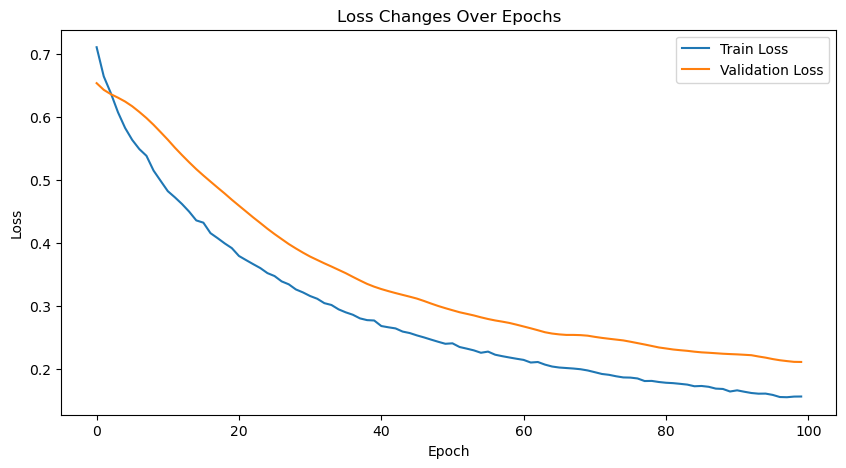

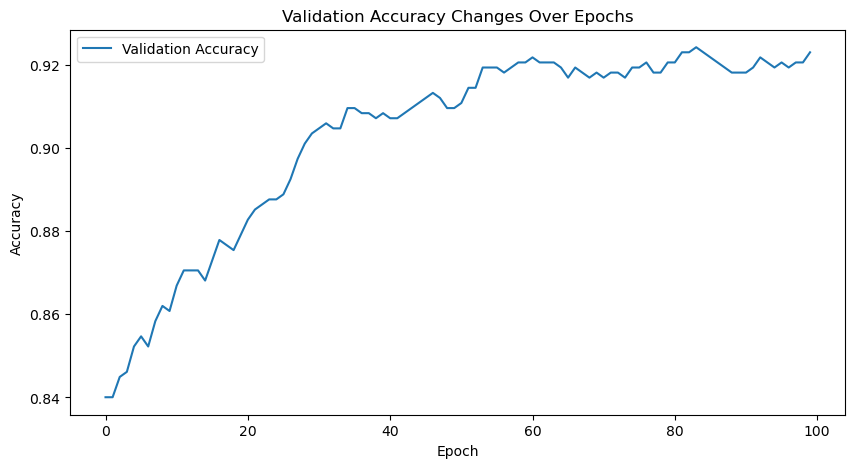

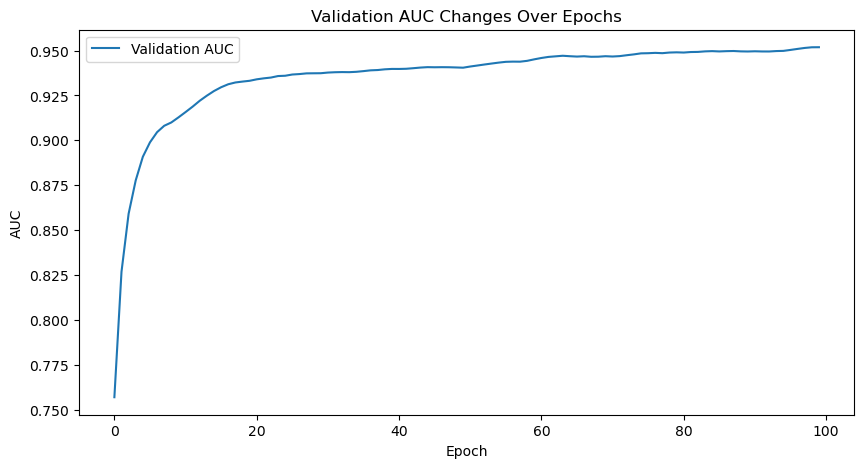

In [58]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

best_val_acc = 0.0
train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []

for epoch in tqdm(range(100), desc="Training Epochs"):
    loss = train_classifier()
    val_loss, val_acc = evaluate_classifier(val_idx)
    train_losses.append(loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Calculate AUC for validation set
    model.eval()
    with torch.no_grad():
        val_logits = model(data.x, data.edge_index).squeeze()
        val_preds = val_logits.sigmoid()
        val_auc = roc_auc_score(data.y[val_idx].cpu(), val_preds[val_idx].cpu())
        val_aucs.append(val_auc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict()
    # Optional: print progress
    # print(f"Epoch {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

# Load the best model
model.load_state_dict(best_state)

test_loss, test_acc = evaluate_classifier(test_idx)
print(f"Test Accuracy: {test_acc:.4f}")

# Calculate AUC for test set
model.eval()
with torch.no_grad():
    test_logits = model(data.x, data.edge_index).squeeze()
    test_preds = test_logits.sigmoid()
    test_auc = roc_auc_score(data.y[test_idx].cpu(), test_preds[test_idx].cpu())
print(f"Test AUC: {test_auc:.4f}")

# Plot the loss changes
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Changes Over Epochs')
plt.show()

# Plot the validation accuracy changes
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Changes Over Epochs')
plt.show()

# Plot the validation AUC changes
plt.figure(figsize=(10, 5))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation AUC Changes Over Epochs')
plt.show()

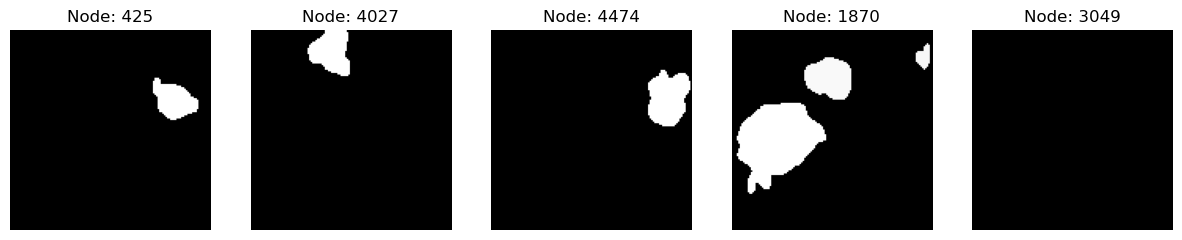

In [97]:
# Get predictions from the classifier
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index).squeeze()
    preds = (logits.sigmoid() > 0.5).float()

# Identify positive nodes
positive_nodes = (preds == 1).nonzero(as_tuple=True)[0]

# Visualize a subset of the positive nodes' patches images
num_images_to_plot = min(5, len(positive_nodes))  # Plot up to 5 images
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))
axes = np.atleast_1d(axes)

# Randomly select positive nodes to plot
random_positive_nodes = random.sample(list(positive_nodes), num_images_to_plot)

for i, node in enumerate(random_positive_nodes):
    patch = data.patches[node].squeeze().numpy()
    axes[i].imshow(patch, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Node: {node.item()}")
plt.show()


## Autoencoder

In [60]:
# Next, define a GAE to get latent representations.

class GAE_Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        z = self.conv2(x, edge_index)
        return z

class InnerProductDecoder(nn.Module):
    def forward(self, z):
        # z: N x d
        return torch.sigmoid(torch.matmul(z, z.t()))

class GAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        adj_pred = self.decoder(z)
        return z, adj_pred


In [61]:
# Prepare adjacency matrix for reconstruction:
adj = to_dense_adj(data.edge_index, max_num_nodes=data.num_nodes).squeeze(0)  # [N, N]
adj = adj.to(torch.float)  # ensure float

In [62]:
# Instantiate and train the GAE
device = "mps" if torch.cuda.is_available() else "cpu"

gae = GAE(
    GAE_Encoder(in_channels=data.x.size(1), hidden_channels=128, out_channels=64),
    InnerProductDecoder()
).to(device)


In [63]:
optimizer_gae = torch.optim.Adam(gae.parameters(), lr=0.001)
gae_criterion = nn.BCELoss()

GAE Training Epochs: 100%|██████████| 50/50 [00:25<00:00,  1.98it/s]


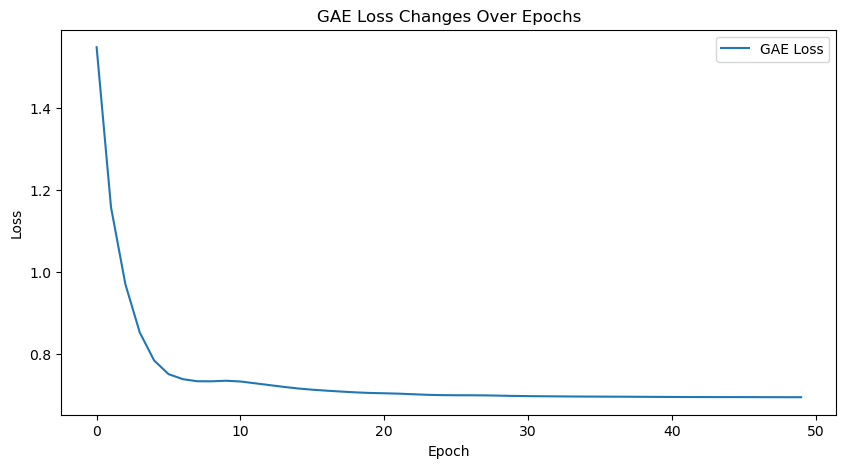

In [64]:
from tqdm import tqdm

def train_gae():
    gae.train()
    optimizer_gae.zero_grad()
    z, adj_pred = gae(data.x, data.edge_index)
    loss_gae = gae_criterion(adj_pred, adj)
    loss_gae.backward()
    optimizer_gae.step()
    return loss_gae.item()

gae_losses = []

for epoch in tqdm(range(50), desc="GAE Training Epochs"):
    loss_gae = train_gae()
    gae_losses.append(loss_gae)
    # Optional: print progress
    # print(f"GAE Epoch {epoch:03d}, Loss: {loss_gae:.4f}")

# Plot the change of loss
plt.figure(figsize=(10, 5))
plt.plot(gae_losses, label='GAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAE Loss Changes Over Epochs')
plt.show()


In [65]:
# After training GAE, get the latent embeddings
gae.eval()
with torch.no_grad():
    z, _ = gae(data.x, data.edge_index) # z: [N, out_channels]

# Extract latent embeddings for positively predicted nodes
positive_latent_embeddings = z[positive_nodes]  # shape: [num_positive_nodes, latent_dim]

print("Latent embeddings for positively predicted nodes obtained. Shape:", positive_latent_embeddings.size())

Latent embeddings for positively predicted nodes obtained. Shape: torch.Size([802, 64])


In [66]:
# Filter for positive nodes
positive_latent_embeddings = z[positive_nodes]  # [num_positive, 64]
positive_patches = data.patches[positive_nodes].permute(0,3,1,2)  # [num_positive, 1, 128, 128]


# Diffusion Model

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj
import numpy as np
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

/Users/jay/micromamba/envs/pytorch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/jay/micromamba/envs/pytorch/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <85A36C65-3F71-3C3B-B529-961AE17DBE73> /Users/jay/micromamba/envs/pytorch/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/jay/micromamba/envs/pytorch/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [31]:
device = "mps" if torch.mps.is_available() else "cpu"

In [44]:
# Create a dataset of only positive patches
class PositivePatchDataset(Dataset):
    def __init__(self, patches):
        self.patches = patches
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
        ])

    def __len__(self):
        return self.patches.size(0)

    def __getitem__(self, idx):
        patch = self.patches[idx]  # [1,128,128]
        # Convert to PIL and back to tensor for augmentations
        patch_np = (patch.squeeze(0).cpu().numpy() * 255).astype(np.uint8)
        # Now apply transforms
        patch_pil = transforms.ToPILImage()(patch_np)
        patch_pil = self.transform(patch_pil)
        patch_tensor = transforms.ToTensor()(patch_pil)  # [1,128,128], float in [0,1]
        return patch_tensor

positive_dataset = PositivePatchDataset(positive_patches)
plaque_loader = DataLoader(positive_dataset, batch_size=32, shuffle=True)


AttributeError: 'dict' object has no attribute 'size'

In [ ]:
#------------------------------------------------------------
# VAE for Plaque Images
#------------------------------------------------------------


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.0, transpose=False):
        super().__init__()
        if in_channels != out_channels or stride != 1:
            if not transpose:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )
            else:
                self.shortcut = nn.Sequential(
                    nn.ConvTranspose2d(in_channels, out_channels, 1, stride=stride,
                                       output_padding=(stride-1), bias=False),
                    nn.BatchNorm2d(out_channels)
                )
        else:
            self.shortcut = nn.Identity()

        if not transpose:
            self.res_block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.res_block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1,
                                   output_padding=stride-1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.res_block(x)
        return F.relu(out + shortcut, inplace=True)

class Encoder(nn.Module):
    def __init__(self, latent_dim=128, in_channels=1, dropout=0.5):
        super().__init__()
        self.block1 = ResidualBlock(in_channels, 32, stride=2, dropout=dropout)
        self.block2 = ResidualBlock(32, 64, stride=2, dropout=dropout)
        self.block3 = ResidualBlock(64, 128, stride=2, dropout=dropout)
        self.block4 = ResidualBlock(128, 256, stride=2, dropout=dropout)
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.contiguous().view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=128, out_channels=1, dropout=0.5):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 8 * 8)
        self.block1 = ResidualBlock(256, 128, stride=2, dropout=dropout, transpose=True)
        self.block2 = ResidualBlock(128, 64, stride=2, dropout=dropout, transpose=True)
        self.block3 = ResidualBlock(64, 32, stride=2, dropout=dropout, transpose=True)
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, out_channels, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z, target_shape=None):
        z = self.fc(z)
        z = z.view(z.size(0), 256, 8, 8)
        z = self.block1(z)
        z = self.block2(z)
        z = self.block3(z)
        x = self.final_conv(z)
        if target_shape is not None:
            x = F.interpolate(x, size=target_shape[2:], mode='bilinear', align_corners=False)
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim=128, in_channels=1, out_channels=1, dropout=0.25):
        super().__init__()
        self.encoder = Encoder(latent_dim, in_channels, dropout)
        self.decoder = Decoder(latent_dim, out_channels, dropout)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z, target_shape=x.shape)
        return recon_x, mu, logvar

def vae_loss(recon_x, x, mu, logvar, epoch, total_epochs):
    kl_weight = min(1.0, epoch / total_epochs)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss



vae = VAE(latent_dim=256, in_channels=1, out_channels=1, dropout=0.2).to(device)

optimizer_vae = torch.optim.Adam(vae.parameters(), lr=1e-4)

def train_vae(vae, dataloader, optimizer, epochs=30, device=device, patience=4, clip_value=5.0):
    vae.to(device)
    vae.train()
    loss_history = []
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        train_loss = 0
        count = 0
        for batch in tqdm(dataloader, desc=f"VAE Epoch {epoch+1}/{epochs}"):
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(batch)
            loss = vae_loss(recon_batch, batch, mu, logvar, epoch, epochs)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), clip_value)
            optimizer.step()
            train_loss += loss.item()
            count += 1
        avg_loss = train_loss / (count*batch.size(0))
        print(f"VAE Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        loss_history.append(avg_loss)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            best_state = vae.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("VAE Early stopping triggered")
                break
    vae.load_state_dict(best_state)
    return vae, loss_history

vae, vae_loss_history = train_vae(vae, plaque_loader, optimizer_vae, epochs=30)

VAE Epoch 1/30: 100%|██████████| 26/26 [00:05<00:00,  4.73it/s]


VAE Epoch 1, Loss: 39029.2700


VAE Epoch 2/30: 100%|██████████| 26/26 [00:04<00:00,  5.29it/s]


VAE Epoch 2, Loss: 24047.1622


VAE Epoch 3/30: 100%|██████████| 26/26 [00:04<00:00,  5.27it/s]


VAE Epoch 3, Loss: 15107.7213


VAE Epoch 4/30: 100%|██████████| 26/26 [00:04<00:00,  5.23it/s]


VAE Epoch 4, Loss: 9850.0542


VAE Epoch 5/30: 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]


VAE Epoch 5, Loss: 6600.0667


VAE Epoch 6/30: 100%|██████████| 26/26 [00:04<00:00,  5.36it/s]


VAE Epoch 6, Loss: 4602.6646


VAE Epoch 7/30: 100%|██████████| 26/26 [00:04<00:00,  5.22it/s]


VAE Epoch 7, Loss: 3478.0857


VAE Epoch 8/30: 100%|██████████| 26/26 [00:04<00:00,  5.22it/s]


VAE Epoch 8, Loss: 2819.9570


VAE Epoch 9/30: 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]


VAE Epoch 9, Loss: 2495.5310


VAE Epoch 10/30: 100%|██████████| 26/26 [00:05<00:00,  4.93it/s]


VAE Epoch 10, Loss: 2274.5279


VAE Epoch 11/30: 100%|██████████| 26/26 [00:05<00:00,  4.94it/s]


VAE Epoch 11, Loss: 2142.3463


VAE Epoch 12/30: 100%|██████████| 26/26 [00:05<00:00,  5.09it/s]


VAE Epoch 12, Loss: 2074.2764


VAE Epoch 13/30: 100%|██████████| 26/26 [00:05<00:00,  4.52it/s]


VAE Epoch 13, Loss: 2037.0903


VAE Epoch 14/30: 100%|██████████| 26/26 [00:05<00:00,  4.74it/s]


VAE Epoch 14, Loss: 2002.0829


VAE Epoch 15/30: 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]


VAE Epoch 15, Loss: 1961.5184


VAE Epoch 16/30: 100%|██████████| 26/26 [00:05<00:00,  4.95it/s]


VAE Epoch 16, Loss: 1921.0923


VAE Epoch 17/30: 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]


VAE Epoch 17, Loss: 1948.7890


VAE Epoch 18/30: 100%|██████████| 26/26 [00:05<00:00,  4.73it/s]


VAE Epoch 18, Loss: 1928.6474


VAE Epoch 19/30: 100%|██████████| 26/26 [00:05<00:00,  4.71it/s]


VAE Epoch 19, Loss: 1909.3170


VAE Epoch 20/30: 100%|██████████| 26/26 [00:06<00:00,  4.18it/s]


VAE Epoch 20, Loss: 1903.6269


VAE Epoch 21/30: 100%|██████████| 26/26 [00:05<00:00,  4.34it/s]


VAE Epoch 21, Loss: 1889.2036


VAE Epoch 22/30: 100%|██████████| 26/26 [00:05<00:00,  4.82it/s]


VAE Epoch 22, Loss: 1889.9095


VAE Epoch 23/30: 100%|██████████| 26/26 [00:05<00:00,  4.66it/s]


VAE Epoch 23, Loss: 1893.2159


VAE Epoch 24/30: 100%|██████████| 26/26 [00:05<00:00,  4.69it/s]


VAE Epoch 24, Loss: 1899.6407


VAE Epoch 25/30: 100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


VAE Epoch 25, Loss: 1937.0007


VAE Epoch 26/30: 100%|██████████| 26/26 [00:05<00:00,  4.53it/s]


VAE Epoch 26, Loss: 1869.7657


VAE Epoch 27/30: 100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


VAE Epoch 27, Loss: 1882.5606


VAE Epoch 28/30: 100%|██████████| 26/26 [00:06<00:00,  4.07it/s]


VAE Epoch 28, Loss: 1890.6881


VAE Epoch 29/30: 100%|██████████| 26/26 [00:07<00:00,  3.51it/s]


VAE Epoch 29, Loss: 1873.8092


VAE Epoch 30/30: 100%|██████████| 26/26 [00:06<00:00,  3.77it/s]

VAE Epoch 30, Loss: 1881.8784


In [ ]:
vae.load_state_dict(torch.load("models/first_success_vae.pth"))

/var/folders/f_/dlk4nftn5s3bpdrpz9trm07m0000gn/T/ipykernel_1417/1966788695.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("models/first_s

<All keys matched successfully>

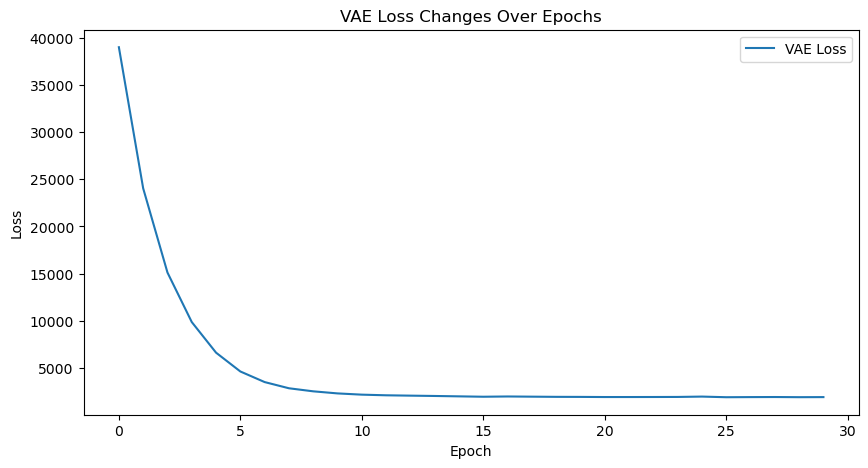

In [345]:
# Visualize the loss history
plt.figure(figsize=(10, 5))
plt.plot(vae_loss_history, label='VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('VAE Loss Changes Over Epochs')
plt.show()


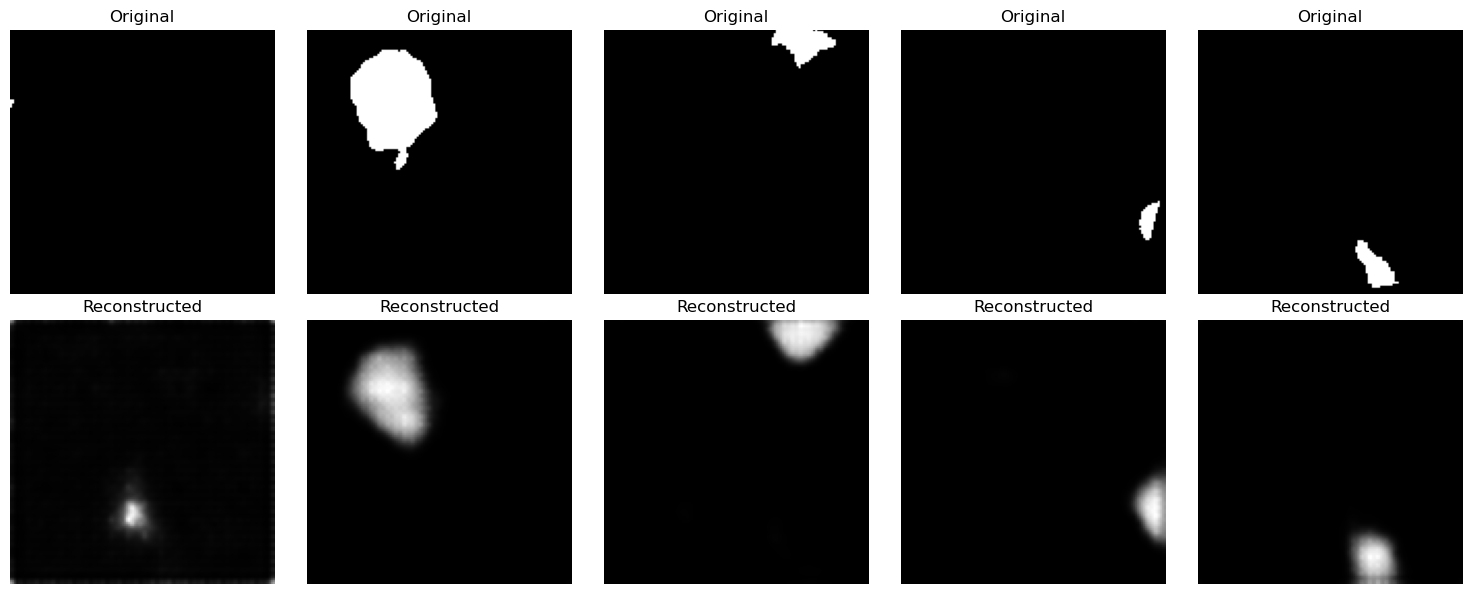

In [353]:
# Test the vae on a batch of positive patches
vae.eval()
with torch.no_grad():
    batch = next(iter(plaque_loader)).to(device)
    recon_batch, mu, logvar = vae(batch)
    recon_batch = recon_batch.cpu()

# Plot the original and reconstructed patches
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(5):
    axes[i].imshow(batch[i].squeeze().cpu(), cmap='gray')
    axes[i].set_title("Original")
    axes[i].axis('off')
    axes[i+5].imshow(recon_batch[i].squeeze(), cmap='gray')
    axes[i+5].set_title("Reconstructed")
    axes[i+5].axis('off')
plt.tight_layout()
plt.show()


In [315]:
vae.eval()
batch_size = 32
for i in range(0, positive_patches.size(0), batch_size):
    batch = positive_patches[i:i+batch_size].to(device)
    with torch.no_grad():
        mu, logvar = vae.encoder(batch)
        if torch.isinf(mu).any() or torch.isinf(logvar).any():
            print(f"Batch {i//batch_size}: mu has Inf: {torch.isinf(mu).any()}, logvar has Inf: {torch.isinf(logvar).any()}")
            # Optionally, inspect the specific values
            print(f"mu: {mu}")
            print(f"logvar: {logvar}")
            break


In [316]:
for name, param in vae.named_parameters():
    if torch.isnan(param).any() or torch.isinf(param).any():
        print(f"Parameter {name} contains NaNs or Infs")


In [295]:
#------------------------------------------------------------
# Diffusion Model with Conditioning on GAE Embeddings
#------------------------------------------------------------
def timestep_embedding(timesteps, dim=128, max_period=10000):
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim % 2 == 1:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class MLPDiffusionModel(nn.Module):
    def __init__(self, latent_dim=128, time_embed_dim=128, conditioning_dim=64, hidden_dim=512, num_layers=4):
        super().__init__()
        self.latent_dim = latent_dim
        self.time_embed_dim = time_embed_dim
        self.conditioning_dim = conditioning_dim

        self.time_mlp = nn.Sequential(
            nn.Linear(time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )

        self.cond_mlp = nn.Sequential(
            nn.Linear(conditioning_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )

        input_dim = latent_dim + 2 * hidden_dim
        layers = []
        dim = input_dim
        for i in range(num_layers):
            layers.append(nn.Linear(dim, hidden_dim))
            layers.append(nn.SiLU())
            layers.append(nn.LayerNorm(hidden_dim))
            dim = hidden_dim
        layers.append(nn.Linear(dim, latent_dim))
        self.mlp = nn.Sequential(*layers)

    def forward(self, z_t, t, c):
        t_emb = timestep_embedding(t, dim=self.time_embed_dim)
        t_emb = self.time_mlp(t_emb)
        c_emb = self.cond_mlp(c)
        h = torch.cat([z_t, t_emb, c_emb], dim=1)
        return self.mlp(h)

def make_beta_schedule(n_timestep=1000, start=1e-4, end=2e-3):
    return torch.linspace(start, end, n_timestep)

class DiffusionWrapper:
    def __init__(self, n_timestep=1000, device=device):
        self.device = device
        self.n_timestep = n_timestep
        self.betas = make_beta_schedule(n_timestep).to(self.device)
        self.alphas = (1.0 - self.betas).to(self.device)
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).to(self.device)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=self.device), self.alphas_cumprod[:-1]], dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start, device=self.device)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1,1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1,1)
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

# We'll train the diffusion model on (z_0 from VAE encoder) and condition on GAE embeddings
# To train diffusion, we need pairs (latent from VAE, conditioning vector).
# positive_latent_embeddings: [num_positive, 64]
# We'll re-encode the patches with the trained VAE to get latent codes.

In [283]:
vae.eval()
all_z0 = []
batch_size = 32
for i in range(0, positive_patches.size(0), batch_size):
    batch = positive_patches[i:i+batch_size].to(device)
    with torch.no_grad():
        mu, logvar = vae.encoder(batch)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z0_batch = mu + eps * std
        all_z0.append(z0_batch)
all_z0 = torch.cat(all_z0, dim=0) # [num_positive, latent_dim=128]


In [288]:
mu, logvar = vae.encoder(batch)
print("VAE mu stats:", mu.min().item(), mu.max().item(), mu.mean().item())
print("VAE logvar stats:", logvar.min().item(), logvar.max().item(), logvar.mean().item())


VAE mu stats: -51.59794998168945 52.7139892578125 0.05408698320388794
VAE logvar stats: -49.97774124145508 18.99867820739746 -5.603203296661377


In [308]:
# Create a dataset for diffusion training
class DiffusionDataset(Dataset):
    def __init__(self, latents, conditions):
        assert latents.size(0) == conditions.size(0)
        self.latents = latents
        self.conditions = conditions
    def __len__(self):
        return self.latents.size(0)
    def __getitem__(self, idx):
        return self.latents[idx], self.conditions[idx]

diff_dataset = DiffusionDataset(all_z0, positive_latent_embeddings)
diff_loader = DataLoader(diff_dataset, batch_size=32, shuffle=True)

n_timestep = 1000
diffusion = DiffusionWrapper(n_timestep=n_timestep, device=device)
diffusion_model = MLPDiffusionModel(latent_dim=128, time_embed_dim=128, conditioning_dim=64, hidden_dim=512, num_layers=4).to(device)
opt_diff = torch.optim.AdamW(diffusion_model.parameters(), lr=1e-5)

# def initialize_weights(m):
#     if isinstance(m, nn.Linear):
#         nn.init.xavier_uniform_(m.weight)
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)

# diffusion_model.apply(initialize_weights)


In [314]:
assert not torch.isnan(all_z0).any(), "NaNs found in all_z0"
assert not torch.isinf(all_z0).any(), "Infs found in all_z0"
assert not torch.isnan(positive_latent_embeddings).any(), "NaNs found in positive_latent_embeddings"
assert not torch.isinf(positive_latent_embeddings).any(), "Infs found in positive_latent_embeddings"


AssertionError: Infs found in all_z0

In [304]:
epochs = 20
for epoch in range(epochs):
    diffusion_model.train()
    epoch_loss = 0
    count = 0
    for lat_batch, c_batch in tqdm(diff_loader, desc=f"Diffusion Epoch {epoch+1}/{epochs}"):
        lat_batch = lat_batch.to(device)
        c_batch = c_batch.to(device)
        t = torch.randint(0, n_timestep, (lat_batch.size(0),), device=device).long()
        noise = torch.randn_like(lat_batch)
        z_noisy = diffusion.q_sample(lat_batch, t, noise=noise)
        noise_pred = diffusion_model(z_noisy, t, c_batch)
        loss = F.mse_loss(noise_pred, noise)
        opt_diff.zero_grad()
        loss.backward()
        opt_diff.step()
        epoch_loss += loss.item()
        count += 1
    print(f"Diffusion Epoch {epoch+1}, Avg Loss: {epoch_loss/count:.4f}")


Diffusion Epoch 1/20: 100%|██████████| 26/26 [00:01<00:00, 17.26it/s]


Diffusion Epoch 1, Avg Loss: nan


Diffusion Epoch 2/20: 100%|██████████| 26/26 [00:00<00:00, 47.37it/s]


Diffusion Epoch 2, Avg Loss: nan


Diffusion Epoch 3/20: 100%|██████████| 26/26 [00:00<00:00, 46.63it/s]


Diffusion Epoch 3, Avg Loss: nan


Diffusion Epoch 4/20: 100%|██████████| 26/26 [00:00<00:00, 41.67it/s]


Diffusion Epoch 4, Avg Loss: nan


Diffusion Epoch 5/20: 100%|██████████| 26/26 [00:00<00:00, 42.99it/s]


Diffusion Epoch 5, Avg Loss: nan


Diffusion Epoch 6/20:  92%|█████████▏| 24/26 [00:00<00:00, 51.82it/s]


KeyboardInterrupt: 

In [192]:
data.patches = data.patches.float() / 255.0
# if your images were originally byte [0,255], ensure this step


In [195]:
mu, logvar = vae.encoder(batch)
print("VAE mu stats:", mu.min().item(), mu.max().item(), mu.mean().item())
print("VAE logvar stats:", logvar.min().item(), logvar.max().item(), logvar.mean().item())


VAE mu stats: -38.32417297363281 37.677642822265625 -0.49077704548835754
VAE logvar stats: -28.56098175048828 12.546944618225098 -3.3306965827941895


In [196]:
print("positive_patches stats:", positive_patches.min().item(), positive_patches.max().item(), positive_patches.mean().item())


positive_patches stats: 0.0 217.0 3.8039867877960205


# Try Convolutional VAE (feature map)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.0, transpose=False):
        super().__init__()
        if in_channels != out_channels or stride != 1:
            if not transpose:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )
            else:
                self.shortcut = nn.Sequential(
                    nn.ConvTranspose2d(in_channels, out_channels, 1, stride=stride,
                                       output_padding=(stride-1), bias=False),
                    nn.BatchNorm2d(out_channels)
                )
        else:
            self.shortcut = nn.Identity()

        if not transpose:
            self.res_block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.SiLU(inplace=True),
                nn.Dropout(dropout),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.res_block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1,
                                   output_padding=stride-1),
                nn.BatchNorm2d(out_channels),
                nn.SiLU(inplace=True),
                nn.Dropout(dropout),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.res_block(x)
        return F.relu(out + shortcut, inplace=True)

class Encoder(nn.Module):
    def __init__(self, latent_channels=128, in_channels=1, dropout=0.5):
        super().__init__()
        self.block1 = ResidualBlock(in_channels, 32, stride=2, dropout=dropout)
        self.block2 = ResidualBlock(32, 64, stride=2, dropout=dropout)
        self.block3 = ResidualBlock(64, 128, stride=2, dropout=dropout)
        self.block4 = ResidualBlock(128, 256, stride=2, dropout=dropout)
        # Use convolutional layers for mu and logvar
        self.conv_mu = nn.Conv2d(256, latent_channels, kernel_size=3, stride=1, padding=1)
        self.conv_logvar = nn.Conv2d(256, latent_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.block1(x)  # [B, 32, H/2, W/2]
        x = self.block2(x)  # [B, 64, H/4, W/4]
        x = self.block3(x)  # [B, 128, H/8, W/8]
        x = self.block4(x)  # [B, 256, H/16, W/16]
        mu = self.conv_mu(x)          # [B, latent_channels, H/16, W/16]
        logvar = self.conv_logvar(x)  # [B, latent_channels, H/16, W/16]
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_channels=128, out_channels=1, dropout=0.5):
        super().__init__()
        # Remove the fully connected layer
        self.block1 = ResidualBlock(latent_channels, 256, stride=2, dropout=dropout, transpose=True)
        self.block2 = ResidualBlock(256, 128, stride=2, dropout=dropout, transpose=True)
        self.block3 = ResidualBlock(128, 64, stride=2, dropout=dropout, transpose=True)
        self.block4 = ResidualBlock(64, 32, stride=2, dropout=dropout, transpose=True)
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, out_channels, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z, target_shape=None):
        z = self.block1(z)  # Upsample
        z = self.block2(z)
        z = self.block3(z)
        z = self.block4(z)
        x = self.final_conv(z)
        if target_shape is not None:
            x = F.interpolate(x, size=target_shape[2:], mode='bilinear', align_corners=False)
        return x

class VAE(nn.Module):
    def __init__(self, latent_channels=128, in_channels=1, out_channels=1, dropout=0.25):
        super().__init__()
        self.encoder = Encoder(latent_channels, in_channels, dropout)
        self.decoder = Decoder(latent_channels, out_channels, dropout)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # [B, C, H, W]
        eps = torch.randn_like(std)    # [B, C, H, W]
        return mu + eps * std          # [B, C, H, W]

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z, target_shape=x.shape)
        return recon_x, mu, logvar
    
def vae_loss(recon_x, x, mu, logvar, epoch, total_epochs):
    """
    Computes the VAE loss function as the sum of reconstruction loss and KL divergence.

    Args:
        recon_x (torch.Tensor): Reconstructed image.
        x (torch.Tensor): Original input image.
        mu (torch.Tensor): Mean from the encoder's latent space.
        logvar (torch.Tensor): Log variance from the encoder's latent space.
        epoch (int): Current epoch number.
        total_epochs (int): Total number of training epochs.

    Returns:
        torch.Tensor: Combined loss.
    """
    # Linearly increase the weight of KL divergence (optional)
    kl_weight = min(1.0, epoch / total_epochs)
    
    # Reconstruction loss: Binary Cross-Entropy
    # Change 'reduction' to 'mean' for average per pixel loss
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
    
    # KL Divergence loss: Sum over all elements
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = recon_loss + kl_weight * kl_loss
    return total_loss



In [34]:
# Use 'latent_channels' instead of 'latent_dim'
vae = VAE(latent_channels=128, in_channels=1, out_channels=1, dropout=0.2).to(device)


In [35]:
# Define the optimizer
optimizer_vae = torch.optim.Adam(vae.parameters(), lr=1e-4)

def train_vae(vae, dataloader, optimizer, epochs=30, device=device, patience=4, clip_value=5.0):
    """
    Trains the VAE model.

    Args:
        vae (nn.Module): The VAE model to train.
        dataloader (DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        epochs (int, optional): Number of training epochs. Defaults to 30.
        device (torch.device, optional): Device to train on. Defaults to device.
        patience (int, optional): Number of epochs with no improvement after which training will be stopped. Defaults to 4.
        clip_value (float, optional): Maximum gradient norm for clipping. Defaults to 5.0.

    Returns:
        nn.Module: Trained VAE model.
        list: History of average losses per epoch.
    """
    vae.to(device)
    vae.train()
    loss_history = []
    best_loss = float('inf')
    patience_counter = 0
    best_state = None  # Initialize best_state

    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        count = 0
        progress_bar = tqdm(dataloader, desc=f"VAE Epoch {epoch}/{epochs}", leave=False)
        
        for batch in progress_bar:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(batch)
            loss = vae_loss(recon_batch, batch, mu, logvar, epoch, epochs)
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(vae.parameters(), clip_value)
            optimizer.step()
            train_loss += loss.item()
            count += 1
            progress_bar.set_postfix({'Batch Loss': loss.item() / batch.size(0)})
        
        # Compute average loss per sample
        avg_loss = train_loss / len(dataloader.dataset)
        print(f"VAE Epoch {epoch}, Average Loss: {avg_loss:.4f}")
        loss_history.append(avg_loss)
        
        # Early Stopping Check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            best_state = vae.state_dict()
            print(f"  New best loss: {best_loss:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("VAE Early stopping triggered")
                break

    # Load the best model state
    if best_state is not None:
        vae.load_state_dict(best_state)
    else:
        print("No improvement during training.")

    return vae, loss_history



In [36]:
# Example usage:
vae, vae_loss_history = train_vae(vae, plaque_loader, optimizer_vae, epochs=15)

VAE Epoch 1, Average Loss: 0.0217
  New best loss: 0.0217


VAE Epoch 2, Average Loss: 0.0138
  New best loss: 0.0138


VAE Epoch 3, Average Loss: 0.0090
  New best loss: 0.0090


VAE Epoch 4, Average Loss: 0.0064
  New best loss: 0.0064


VAE Epoch 5, Average Loss: 0.0049
  New best loss: 0.0049


VAE Epoch 6, Average Loss: 0.0040
  New best loss: 0.0040


VAE Epoch 7, Average Loss: 0.0034
  New best loss: 0.0034


VAE Epoch 8, Average Loss: 0.0029
  New best loss: 0.0029


VAE Epoch 9, Average Loss: 0.0026
  New best loss: 0.0026


VAE Epoch 10, Average Loss: 0.0024
  New best loss: 0.0024


VAE Epoch 11, Average Loss: 0.0022
  New best loss: 0.0022


VAE Epoch 12, Average Loss: 0.0020
  New best loss: 0.0020


VAE Epoch 13, Average Loss: 0.0019
  New best loss: 0.0019


VAE Epoch 14, Average Loss: 0.0018
  New best loss: 0.0018


VAE Epoch 15, Average Loss: 0.0017
  New best loss: 0.0017


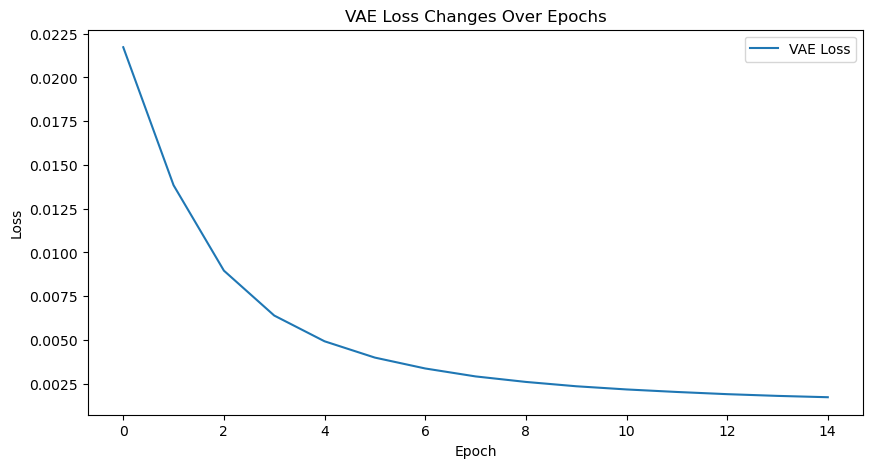

In [37]:
# Visualize the loss history
plt.figure(figsize=(10, 5))
plt.plot(vae_loss_history, label='VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('VAE Loss Changes Over Epochs')
plt.show()


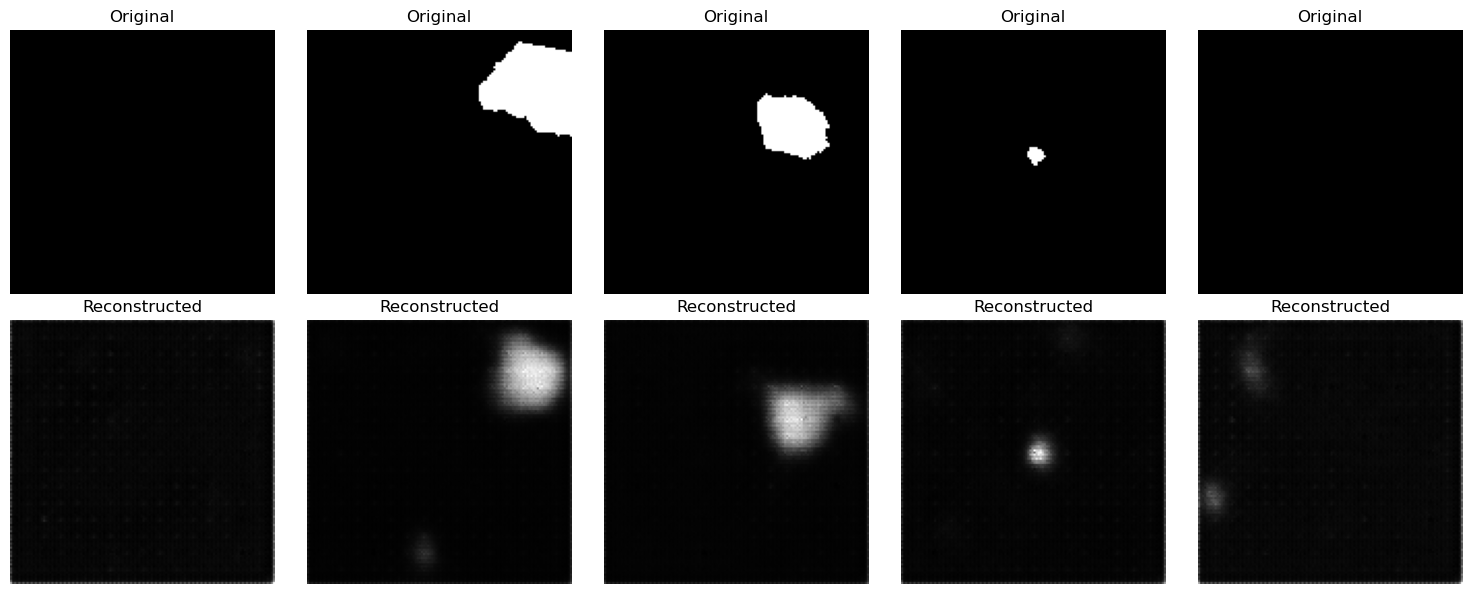

In [46]:
# Test the vae on a batch of positive patches
vae.eval()
with torch.no_grad():
    batch = next(iter(plaque_loader)).to(device)
    recon_batch, mu, logvar = vae(batch)
    recon_batch = recon_batch.cpu()

# Plot the original and reconstructed patches
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(5):
    axes[i].imshow(batch[i].squeeze().cpu(), cmap='gray')
    axes[i].set_title("Original")
    axes[i].axis('off')
    axes[i+5].imshow(recon_batch[i].squeeze(), cmap='gray')
    axes[i+5].set_title("Reconstructed")
    axes[i+5].axis('off')
plt.tight_layout()
plt.show()


# Attention Mechanism

In [67]:
positive_patches.shape

torch.Size([802, 1, 128, 128])

In [68]:
# Import transform functions from torchvision
import torchvision.transforms as transforms

# Create a dataset of only positive patches
class PositivePatchDataset(Dataset):
    def __init__(self, patches):
        self.patches = patches
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
        ])

    def __len__(self):
        return self.patches.size(0)

    def __getitem__(self, idx):
        patch = self.patches[idx]  # [1,128,128]
        # Convert to PIL and back to tensor for augmentations
        patch_np = (patch.squeeze(0).cpu().numpy() * 255).astype(np.uint8)
        # Now apply transforms
        patch_pil = transforms.ToPILImage()(patch_np)
        patch_pil = self.transform(patch_pil)
        patch_tensor = transforms.ToTensor()(patch_pil)  # [1,128,128], float in [0,1]
        return patch_tensor

positive_dataset = PositivePatchDataset(positive_patches)
plaque_loader = DataLoader(positive_dataset, batch_size=32, shuffle=True)


In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        # Channel Attention Module
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        # Spatial Attention Module
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Channel Attention
        ca = self.channel_attention(x)
        x = x * ca
        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        sa = self.spatial_attention(torch.cat([avg_out, max_out], dim=1))
        x = x * sa
        return x


In [70]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.0, transpose=False):
        super(ResidualBlock, self).__init__()
        self.transpose = transpose
        self.stride = stride

        # Define the shortcut connection
        if in_channels != out_channels or stride != 1:
            if not transpose:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )
            else:
                self.shortcut = nn.Sequential(
                    nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=stride,
                                       output_padding=stride-1, bias=False),
                    nn.BatchNorm2d(out_channels)
                )
        else:
            self.shortcut = nn.Identity()

        # Define the main residual path
        if not transpose:
            self.res_block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.SiLU(inplace=True),
                nn.Dropout(dropout),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.res_block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1,
                                   output_padding=stride-1),
                nn.BatchNorm2d(out_channels),
                nn.SiLU(inplace=True),
                nn.Dropout(dropout),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.res_block(x)
        out += shortcut
        return F.relu(out, inplace=True)


In [71]:
class Encoder(nn.Module):
    def __init__(self, latent_channels=128, in_channels=1, dropout=0.5):
        super(Encoder, self).__init__()
        self.block1 = ResidualBlock(in_channels, 32, stride=2, dropout=dropout)
        self.cbam1 = CBAM(32)
        self.block2 = ResidualBlock(32, 64, stride=2, dropout=dropout)
        self.cbam2 = CBAM(64)
        self.block3 = ResidualBlock(64, 128, stride=2, dropout=dropout)
        self.cbam3 = CBAM(128)
        self.block4 = ResidualBlock(128, 256, stride=2, dropout=dropout)
        self.cbam4 = CBAM(256)
        
        # Convolutional layers for mu and logvar
        self.conv_mu = nn.Conv2d(256, latent_channels, kernel_size=3, stride=1, padding=1)
        self.conv_logvar = nn.Conv2d(256, latent_channels, kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.cbam1(x)
        x = self.block2(x)
        x = self.cbam2(x)
        x = self.block3(x)
        x = self.cbam3(x)
        x = self.block4(x)
        x = self.cbam4(x)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        return mu, logvar


In [72]:
class Decoder(nn.Module):
    def __init__(self, latent_channels=128, out_channels=1, dropout=0.5):
        super(Decoder, self).__init__()
        self.block1 = ResidualBlock(latent_channels, 256, stride=2, dropout=dropout, transpose=True)
        self.cbam1 = CBAM(256)
        self.block2 = ResidualBlock(256, 128, stride=2, dropout=dropout, transpose=True)
        self.cbam2 = CBAM(128)
        self.block3 = ResidualBlock(128, 64, stride=2, dropout=dropout, transpose=True)
        self.cbam3 = CBAM(64)
        self.block4 = ResidualBlock(64, 32, stride=2, dropout=dropout, transpose=True)
        self.cbam4 = CBAM(32)
        
        # Final convolution to get the output
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, z, target_shape=None):
        z = self.block1(z)
        z = self.cbam1(z)
        z = self.block2(z)
        z = self.cbam2(z)
        z = self.block3(z)
        z = self.cbam3(z)
        z = self.block4(z)
        z = self.cbam4(z)
        x = self.final_conv(z)
        
        # Optional: Resize to target shape if provided
        if target_shape is not None:
            x = F.interpolate(x, size=target_shape[2:], mode='bilinear', align_corners=False)
        return x


In [73]:
class VAE(nn.Module):
    def __init__(self, latent_channels=128, in_channels=1, out_channels=1, dropout=0.25):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_channels, in_channels, dropout)
        self.decoder = Decoder(latent_channels, out_channels, dropout)
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)    # Epsilon ~ N(0,1)
        return mu + eps * std          # Sampled latent vector
    
    def forward(self, x):
        mu, logvar = self.encoder(x)    # Encode input to latent space
        z = self.reparameterize(mu, logvar)  # Sample from latent space
        recon_x = self.decoder(z, target_shape=x.shape)  # Decode to reconstruct
        return recon_x, mu, logvar


In [74]:
class VAE(nn.Module):
    def __init__(self, latent_channels=128, in_channels=1, out_channels=1, dropout=0.25):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_channels, in_channels, dropout)
        self.decoder = Decoder(latent_channels, out_channels, dropout)
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)    # Epsilon ~ N(0,1)
        return mu + eps * std          # Sampled latent vector
    
    def forward(self, x):
        mu, logvar = self.encoder(x)    # Encode input to latent space
        z = self.reparameterize(mu, logvar)  # Sample from latent space
        recon_x = self.decoder(z, target_shape=x.shape)  # Decode to reconstruct
        return recon_x, mu, logvar


In [75]:
# Define the device: use GPU if available, else CPU
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [76]:
def vae_loss(recon_x, x, mu, logvar, epoch, total_epochs):
    """
    Computes the VAE loss function as the sum of reconstruction loss and KL divergence.

    Args:
        recon_x (torch.Tensor): Reconstructed image.
        x (torch.Tensor): Original input image.
        mu (torch.Tensor): Mean from the encoder's latent space.
        logvar (torch.Tensor): Log variance from the encoder's latent space.
        epoch (int): Current epoch number.
        total_epochs (int): Total number of training epochs.

    Returns:
        torch.Tensor: Combined loss.
    """
    # Linearly increase the weight of KL divergence (optional)
    kl_weight = min(1.0, epoch / total_epochs)
    
    # Reconstruction loss: Binary Cross-Entropy
    # Change 'reduction' to 'mean' for average per pixel loss
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
    
    # KL Divergence loss: Sum over all elements
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = recon_loss + kl_weight * kl_loss
    return total_loss


In [77]:
def train_vae(vae, dataloader, optimizer, epochs=30, device=device, patience=4, clip_value=5.0, scheduler=None, verbose=True):
    """
    Trains the VAE model with integrated CBAM attention mechanisms.

    Args:
        vae (nn.Module): The VAE model to train.
        dataloader (DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        epochs (int, optional): Number of training epochs. Defaults to 30.
        device (torch.device, optional): Device to train on. Defaults to device.
        patience (int, optional): Number of epochs with no improvement after which training will be stopped. Defaults to 4.
        clip_value (float, optional): Maximum gradient norm for clipping. Defaults to 5.0.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Defaults to None.
        verbose (bool, optional): If True, prints training progress. Defaults to True.

    Returns:
        nn.Module: Trained VAE model.
        list: History of average losses per epoch.
    """
    vae.to(device)
    vae.train()
    loss_history = []
    best_loss = float('inf')
    patience_counter = 0
    best_state = None  # Initialize best_state

    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        count = 0
        progress_bar = tqdm(dataloader, desc=f"VAE Epoch {epoch}/{epochs}", leave=False) if verbose else dataloader

        for batch in progress_bar:
            # If your DataLoader returns a tuple (data, labels), adjust accordingly
            # Assuming batch is the input data
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(batch)
            loss = vae_loss(recon_batch, batch, mu, logvar, epoch, epochs)
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(vae.parameters(), clip_value)
            optimizer.step()
            train_loss += loss.item()
            count += 1
            if verbose:
                progress_bar.set_postfix({'Batch Loss': loss.item() / batch.size(0)})

        # Optional: Step the scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # Compute average loss per sample
        avg_loss = train_loss / len(dataloader.dataset)
        if verbose:
            print(f"VAE Epoch {epoch}, Average Loss: {avg_loss:.4f}")
        loss_history.append(avg_loss)

        # Early Stopping Check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            best_state = vae.state_dict()
            if verbose:
                print(f"  New best loss: {best_loss:.4f}")
        else:
            patience_counter += 1
            if verbose:
                print(f"  No improvement. Patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                if verbose:
                    print("VAE Early stopping triggered")
                break

    # Load the best model state
    if best_state is not None:
        vae.load_state_dict(best_state)
        if verbose:
            print("Loaded the best model state based on validation loss.")
    else:
        if verbose:
            print("No improvement during training.")

    return vae, loss_history


VAE Epoch 1, Average Loss: 0.0123
  New best loss: 0.0123


VAE Epoch 2, Average Loss: 0.0022
  New best loss: 0.0022


VAE Epoch 3, Average Loss: 0.0013
  New best loss: 0.0013


VAE Epoch 4, Average Loss: 0.0012
  New best loss: 0.0012


VAE Epoch 5, Average Loss: 0.0011
  New best loss: 0.0011


VAE Epoch 6, Average Loss: 0.0010
  New best loss: 0.0010


VAE Epoch 7, Average Loss: 0.0010
  New best loss: 0.0010


VAE Epoch 8, Average Loss: 0.0010
  New best loss: 0.0010


VAE Epoch 9, Average Loss: 0.0010
  No improvement. Patience counter: 1/3


VAE Epoch 10, Average Loss: 0.0009
  New best loss: 0.0009


VAE Epoch 11, Average Loss: 0.0010
  No improvement. Patience counter: 1/3


VAE Epoch 12, Average Loss: 0.0010
  No improvement. Patience counter: 2/3


VAE Epoch 13, Average Loss: 0.0010
  No improvement. Patience counter: 3/3
VAE Early stopping triggered
Loaded the best model state based on validation loss.


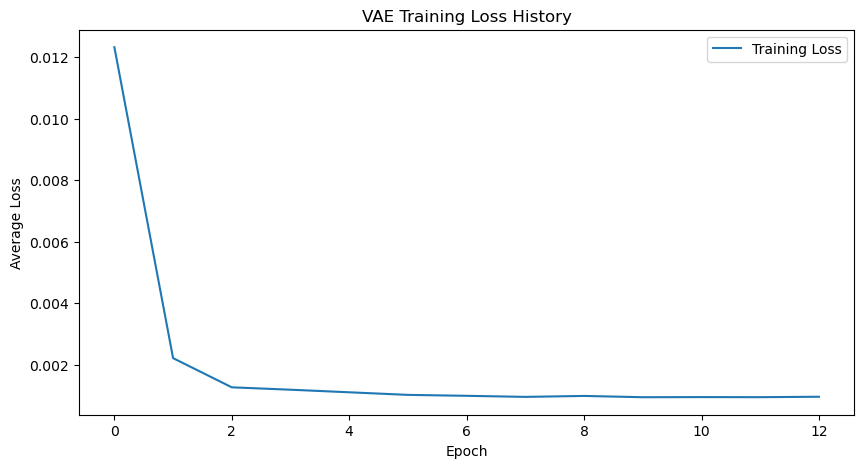

In [78]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR  # Example scheduler

# Instantiate the VAE
vae = VAE(latent_channels=128, in_channels=1, out_channels=1, dropout=0.25)

# Define the optimizer
optimizer_vae = Adam(vae.parameters(), lr=1e-3)

# (Optional) Define a learning rate scheduler
scheduler = StepLR(optimizer_vae, step_size=10, gamma=0.1)

# Assuming you have a DataLoader `train_loader`
# For example:
# from torchvision import datasets, transforms
# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Train the VAE
trained_vae, loss_history = train_vae(
    vae=vae,
    dataloader=plaque_loader,
    optimizer=optimizer_vae,
    epochs=30,
    device=device,
    patience=3,
    clip_value=5.0,
    scheduler=scheduler,  # Pass the scheduler if you have one
    verbose=True
)

# Example: Plotting the loss history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('VAE Training Loss History')
plt.legend()
plt.show()


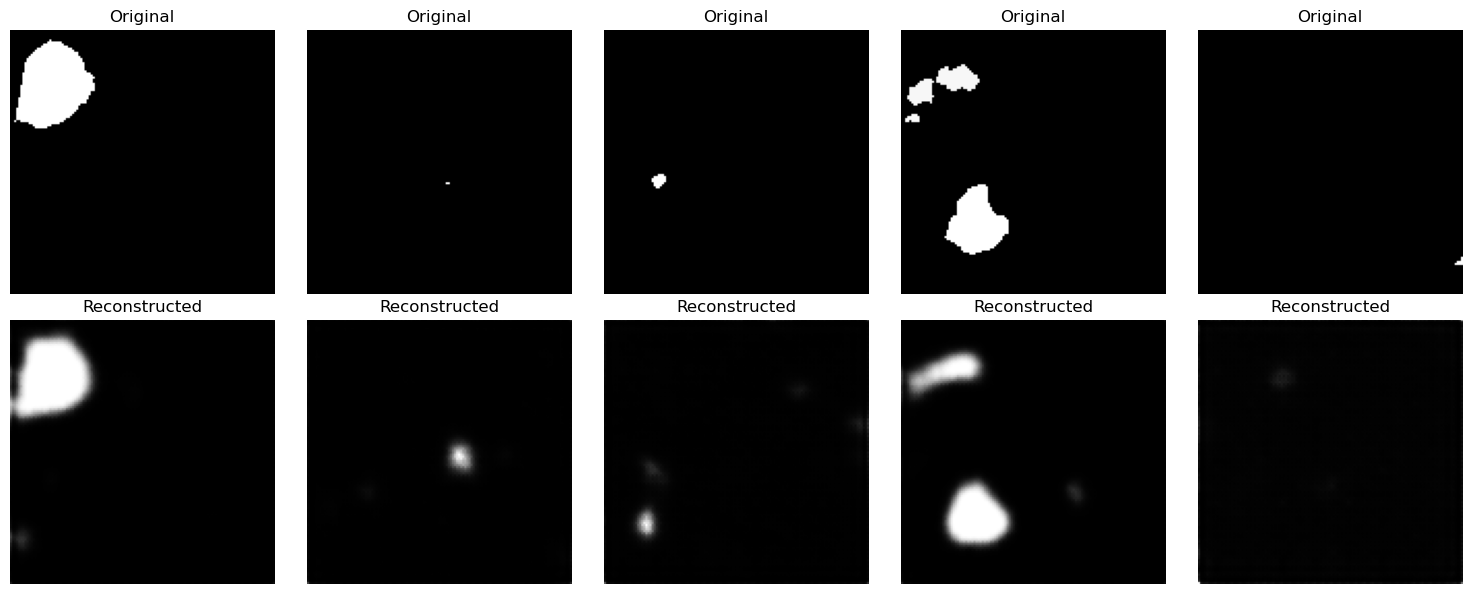

In [80]:
# Test the vae on a batch of positive patches
vae.eval()
with torch.no_grad():
    batch = next(iter(plaque_loader)).to(device)
    recon_batch, mu, logvar = vae(batch)
    recon_batch = recon_batch.cpu()

# Plot the original and reconstructed patches
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(5):
    axes[i].imshow(batch[i].squeeze().cpu(), cmap='gray')
    axes[i].set_title("Original")
    axes[i].axis('off')
    axes[i+5].imshow(recon_batch[i].squeeze(), cmap='gray')
    axes[i+5].set_title("Reconstructed")
    axes[i+5].axis('off')
plt.tight_layout()
plt.show()


In [444]:
torch.save(vae.state_dict(), "models/vae_model_ed.pth")

# Thrid Latent Diffusion

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

In [64]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

class LatentDiffusionModel(nn.Module):
    def __init__(self, vae, timesteps=1000, betas=(1e-4, 0.02)):
        super(LatentDiffusionModel, self).__init__()
        self.vae = vae  # Pre-trained VAE model
        self.timesteps = timesteps
        self.betas = torch.linspace(betas[0], betas[1], timesteps)  # Linear beta schedule

        # Compute alpha_t and alpha_bar_t from betas
        self.alpha_t = 1.0 - self.betas  # alpha_t = 1 - beta_t
        self.alpha_bar_t = torch.cumprod(self.alpha_t, dim=0)  # Cumulative product of alpha_t

        # Denoising UNet Model
        self.denoising_unet = nn.Sequential(
            nn.Conv2d(vae.encoder.conv_mu.out_channels, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, vae.encoder.conv_mu.out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t):
        """
        Perform a forward diffusion step for timestep t.
        """
        device = x.device  # Get the device of input x
        t = t.to(device)   # Move t to the same device as x

        # Get latent representation from the VAE encoder
        z = self.vae.encoder(x)[0]
        z = z.to(device)  # Ensure z is on the same device as x

        # Ensure that alpha_bar_t[t] is broadcasted to the correct shape and on the same device as x
        alpha_bar_t = self.alpha_bar_t.to(device)[t].view(-1, 1, 1, 1).expand_as(z)

        # Generate noise
        noise = torch.randn_like(z).to(device)

        # Add noise to the latent representation (forward diffusion)
        z_t = torch.sqrt(alpha_bar_t) * z + torch.sqrt(1 - alpha_bar_t) * noise
        return z_t

    def reverse_diffusion(self, z_t, t):
        """
        Perform a reverse diffusion step.
        """
        denoised = self.denoising_unet(z_t)
        # Use the denoising UNet to predict the clean latent representation at this timestep
        z_pred = z_t - denoised  # This is a simplified reverse pass
        return z_pred

    def sample(self, shape):
        """
        Sample from the latent space, starting from noise.
        """
        # Sample initial noise in latent space
        z_t = torch.randn(shape).to(device)
        for t in range(self.timesteps-1, -1, -1):
            z_t = self.reverse_diffusion(z_t, t)
        return z_t

    def reconstruct(self, z_t):
        """
        Reconstruct the image from the denoised latent representation.
        """
        return self.vae.decoder(z_t)


In [65]:

def train_latent_diffusion_model(vae, dataset, num_epochs=10, batch_size=32, lr=1e-4, timesteps=1000):
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    
    # Initialize the Latent Diffusion Model
    ldm = LatentDiffusionModel(vae, timesteps=timesteps)
    ldm.to(device)
    
    # DataLoader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Optimizer
    optimizer = optim.Adam(ldm.parameters(), lr=lr)

    # Training loop
    losses = []
    for epoch in range(num_epochs):
        ldm.train()
        running_loss = 0.0
        # tqdm for progress bar
        for batch_idx, data in enumerate(tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100)):
            data = data.to(device)  # move data to device (GPU/CPU)

            # Random timestep for each image in the batch
            t = torch.randint(0, timesteps, (data.size(0),), device=device)

            # Forward pass: Diffuse the data
            z_t = ldm.forward(data, t)
            
            # Reverse diffusion pass (denoise)
            z_pred = ldm.reverse_diffusion(z_t, t)
            
            # Calculate loss (L2 loss between predicted and original latent)
            mu, logvar = vae.encoder(data)
            loss = F.mse_loss(z_pred, mu)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_loss = running_loss / len(data_loader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Plotting the loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_epochs), losses, label='Training Loss', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return ldm, losses

# Function to generate new samples
def generate_samples(vae, latent_diffusion_model, num_samples=10, latent_size=(1, 128, 128)):
    latent_samples = latent_diffusion_model.sample(latent_size)
    generated_images = latent_diffusion_model.reconstruct(latent_samples)
    
    return generated_images

Epoch 1/10: 100%|███████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.72it/s]


Epoch [1/10], Loss: 0.7045


Epoch 2/10: 100%|███████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.02it/s]


Epoch [2/10], Loss: 0.7192


Epoch 3/10: 100%|███████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch [3/10], Loss: 0.6965


Epoch 4/10: 100%|███████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.17it/s]


Epoch [4/10], Loss: 0.7038


Epoch 5/10: 100%|███████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.23it/s]


Epoch [5/10], Loss: 0.6923


Epoch 6/10: 100%|███████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.13it/s]


Epoch [6/10], Loss: 0.6750


Epoch 7/10: 100%|███████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.23it/s]


Epoch [7/10], Loss: 0.6274


Epoch 8/10: 100%|███████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch [8/10], Loss: 0.6195


Epoch 9/10: 100%|███████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch [9/10], Loss: 0.5914


Epoch 10/10: 100%|██████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch [10/10], Loss: 0.5696


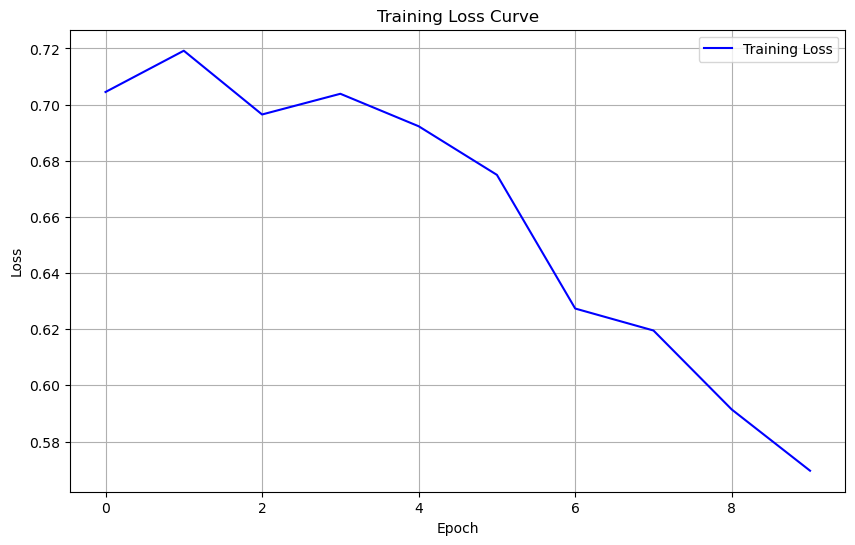

In [66]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")  # Choose the device (CUDA or CPU)

vae.to(device)  # Move VAE model to the same device
ldm = LatentDiffusionModel(vae, timesteps=1000).to(device)  # Move LDM to the same device

# Assuming `positive_dataset` is your dataset and DataLoader is created
ldm, losses = train_latent_diffusion_model(vae, positive_dataset)


In [73]:
import torch
import matplotlib.pyplot as plt

def visualize_generated_images(ldm, num_images=8, image_size=(1, 128, 128)):
    """
    Generate images using Latent Diffusion Model (LDM) and visualize them.
    Args:
    - ldm (LatentDiffusionModel): The trained LDM model.
    - num_images (int): The number of images to generate and display.
    - image_size (tuple): The size of the generated image in the format (channels, height, width).
    """
    # Adjust the latent channels if needed
    num_latent_channels = 128  # Ensure the latent space has the correct number of channels
    
    # Generate latent representations (with the expected number of channels)
    z_t_shape = (num_images, num_latent_channels, *image_size[1:])  # Define shape for random latent tensor
    
    # Perform reverse diffusion to generate clean latent representations
    z_t = ldm.sample(z_t_shape)  # Pass shape, not tensor
    
    # Reconstruct images from latent representations
    generated_images = ldm.reconstruct(z_t)  # Reconstruct images
    
    # Move generated images to CPU for visualization
    generated_images = generated_images.cpu().detach()

    # Convert the images to numpy and normalize to [0, 1]
    generated_images = generated_images.squeeze(1)  # Remove channel dimension if it's 1
    generated_images = generated_images.clamp(0, 1).numpy()

    # Plot the generated images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        axes[i].imshow(generated_images[i], cmap='gray')
        axes[i].axis('off')  # Remove axis labels
    plt.show()



In [77]:
# Assuming ldm is your trained Latent Diffusion Model
visualize_generated_images(ldm, num_images=2, image_size=(1, 128, 128))


RuntimeError: MPS backend out of memory (MPS allocated: 18.12 GB, other allocations: 6.28 MB, max allowed: 18.13 GB). Tried to allocate 16.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

## Latent Diffusion (Second Trial)

In [78]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator, notebook_launcher
from dataclasses import dataclass
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np

In [79]:
class LatentDataset(Dataset):
    def __init__(self, dataloader, vae, device=device):
        """
        Args:
            dataloader (DataLoader): DataLoader for the original dataset.
            vae (nn.Module): Trained VAE model.
            device (torch.device): Device to perform computations.
        """
        self.vae = vae
        self.device = device
        self.latents = []

        self.vae.eval()  # Set VAE to evaluation mode
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Encoding to latents"):
                batch = batch.to(device)
                # Normalize to [-1, 1]
                batch = batch * 2.0 - 1.0
                mu, logvar = self.vae.encoder(batch)
                z = self.vae.reparameterize(mu, logvar)
                self.latents.append(z.cpu())

        self.latents = torch.cat(self.latents, dim=0)

    def __len__(self):
        return self.latents.size(0)

    def __getitem__(self, idx):
        return self.latents[idx]


In [80]:
# Instantiate the LatentDataset
latent_dataset = LatentDataset(plaque_loader, trained_vae, device=device)

# Create a DataLoader for the latent dataset
latent_dataloader = DataLoader(latent_dataset, batch_size=16, shuffle=True)


Encoding to latents: 100%|██████████| 25/25 [00:01<00:00, 18.43it/s]


In [81]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size: int = 128  # Resolution of images
    latent_channels: int = 128  # Latent dimension from VAE
    train_batch_size: int = 16
    eval_batch_size: int = 16
    num_epochs: int = 50
    gradient_accumulation_steps: int = 1
    learning_rate: float = 1e-4
    lr_warmup_steps: int = 500
    save_image_epochs: int = 10
    save_model_epochs: int = 30
    mixed_precision: str = "no"  # Use "fp16" for mixed precision
    output_dir: str = "ldm-plaque-128"
    
    push_to_hub: bool = False  # Set to True if uploading to HF Hub
    hub_model_id: str = "<your-username>/ldm-plaque-128"  # Replace with your Hugging Face username and desired repo name
    hub_private_repo: bool = False
    overwrite_output_dir: bool = True
    seed: int = 42

config = TrainingConfig()


In [82]:
# Step 3: Define the Diffusion Model with Correct `sample_size`
diffusion_model = UNet2DModel(
    sample_size=config.image_size // 16,  # Adjusted from 16 to 8
    in_channels=config.latent_channels,   # 128
    out_channels=config.latent_channels,  # 128
    layers_per_block=2,
    block_out_channels=(128, 256, 512),    # Reduced to 3 blocks
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
).to(device)

# Quick shape check
sample_latent = next(iter(latent_dataloader)).to(device)  # [16, 128, 8, 8]
print("Sample latent shape:", sample_latent.shape)  # Expected: [16, 128, 8, 8]

# Define a batch of timesteps matching the batch size
timesteps = torch.zeros(sample_latent.shape[0], dtype=torch.long, device=device)  # [16]

# Forward pass
model_output = diffusion_model(sample_latent, timesteps).sample
print("Model output shape:", model_output.shape)  # Should be [16, 128, 8, 8]


Sample latent shape: torch.Size([16, 128, 8, 8])
Model output shape: torch.Size([16, 128, 8, 8])


In [83]:
# Step 4: Define the Scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Step 5: Define Optimizer and Learning Rate Scheduler
optimizer = torch.optim.AdamW(diffusion_model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(latent_dataloader) * config.num_epochs),
)


In [90]:
from PIL import Image
import numpy as np

def evaluate(config, epoch, pipeline):
    # Sample images from the diffusion model
    output = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed),
        output_type="numpy"  # Ensure the output type is numpy
    )

    # Ensure the output contains images
    images = output.images

    # Check if images is a tensor or numpy array and convert accordingly
    if isinstance(images, torch.Tensor):
        images = images.cpu().numpy()
    
    # Debugging: print the shape of the first image to check the format
    print(f"Generated images shape: {images.shape}")  # e.g., (batch_size, height, width, channels)

    # Create a list to hold PIL images
    pil_images = []

    # Loop through each image in the batch and process them
    for img in images:
        # Debugging: check the shape before conversion
        print(f"Image shape before conversion: {img.shape}")

        # Check if image is valid for conversion (grayscale or RGB)
        if img.ndim == 3 and img.shape[2] == 128:  # Feature map with 128 channels
            # Take the first channel (or apply a different method to reduce dimensions)
            img = img[:, :, 0]  # Take the first channel (could also use other methods)

            # Normalize or scale the values for visualization
            feature_map_img = np.clip(img, 0, 1)  # Normalize feature map to [0, 1]
            
            # Convert the feature map to a grayscale image
            pil_images.append(Image.fromarray((feature_map_img * 255).astype(np.uint8), mode="L"))
        elif img.ndim == 3 and img.shape[2] in [1, 3]:  # Grayscale or RGB
            img = img.squeeze()  # Remove singleton dimensions (e.g., if batch size is 1)
            if img.ndim == 2:  # If it's grayscale (H, W)
                pil_images.append(Image.fromarray(img, mode="L"))
            elif img.ndim == 3 and img.shape[2] == 3:  # If it's RGB (H, W, 3)
                pil_images.append(Image.fromarray(img, mode="RGB"))
        else:
            # Handle the case where image shape doesn't fit expected formats
            print(f"Skipping invalid image shape: {img.shape}")
            continue

    # Check if we have any valid images
    if len(pil_images) == 0:
        print("No valid images to visualize!")
        return None

    # Create a grid of images (if needed for visualization or saving)
    image_grid = make_image_grid(pil_images, rows=4, cols=4)  # Adjust rows and columns as needed
    return image_grid

def make_image_grid(images, rows, cols):
    """
    Function to create a grid of images from a list of PIL images.
    """
    # Assuming the images list contains PIL images
    width, height = images[0].size
    grid_width = cols * width
    grid_height = rows * height
    
    grid_image = Image.new('RGB', (grid_width, grid_height))
    
    for i, image in enumerate(images):
        row = i // cols
        col = i % cols
        grid_image.paste(image, (col * width, row * height))
    
    return grid_image

In [91]:
# Step 7: Define the Training Loop
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize Accelerator
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    
    # Create Hugging Face repository if pushing to hub
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)

        accelerator.init_trackers("ldm_train")

    # Prepare components with Accelerator
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch+1}/{config.num_epochs}")

        for step, batch in enumerate(train_dataloader):
            clean_latents = batch.to(device)  # [batch_size, latent_channels, H, W]
            noise = torch.randn(clean_latents.shape, device=clean_latents.device)
            bs = clean_latents.shape[0]

            # Sample random timesteps for each sample in the batch
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_latents.device, dtype=torch.long
            )

            # Add noise to the latents
            noisy_latents = noise_scheduler.add_noise(clean_latents, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_latents, timesteps).sample
                loss = F.mse_loss(noise_pred, noise)

                # Backpropagate
                accelerator.backward(loss)

                # Gradient clipping
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                
                # Update parameters
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Update progress bar and log
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        progress_bar.close()

        # Evaluation and saving
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or (epoch + 1) == config.num_epochs:
                evaluate(config, epoch + 1, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or (epoch + 1) == config.num_epochs:
                pipeline.save_pretrained(config.output_dir)

In [92]:
# Step 8: Launch the Training
from accelerate import notebook_launcher

# Define arguments for the training loop
args = (config, diffusion_model, noise_scheduler, optimizer, latent_dataloader, lr_scheduler)

# Launch the training
notebook_launcher(train_loop, args, num_processes=1)

/Users/jay/micromamba/envs/pytorch/lib/python3.11/site-packages/accelerate/accelerator.py:443: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


Launching training on MPS.


Epoch 10/50: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s, loss=0.626, lr=5e-5, step=499]   


  0%|          | 0/1000 [00:00<?, ?it/s]

Generated images shape: (16, 8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)


Epoch 20/50: 100%|██████████| 50/50 [00:25<00:00,  1.97it/s, loss=0.534, lr=1.46e-5, step=999]


  0%|          | 0/1000 [00:00<?, ?it/s]

Generated images shape: (16, 8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)


Epoch 30/50: 100%|██████████| 50/50 [00:23<00:00,  2.17it/s, loss=0.582, lr=0, step=1499]       


  0%|          | 0/1000 [00:00<?, ?it/s]

Generated images shape: (16, 8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)


Epoch 40/50: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s, loss=0.583, lr=1.46e-5, step=1999]


  0%|          | 0/1000 [00:00<?, ?it/s]

Generated images shape: (16, 8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)


Epoch 50/50: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s, loss=0.53, lr=5e-5, step=2499]    


  0%|          | 0/1000 [00:00<?, ?it/s]

Generated images shape: (16, 8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)
Image shape before conversion: (8, 8, 128)


In [93]:
from diffusers import DDPMPipeline

# Load the trained diffusion model
pipeline = DDPMPipeline.from_pretrained(config.output_dir).to(device)

# Ensure the VAE is in evaluation mode
trained_vae.eval()


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

VAE(
  (encoder): Encoder(
    (block1): ResidualBlock(
      (shortcut): Sequential(
        (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (res_block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.25, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (cbam1): CBAM(
      (channel_attention): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): ReLU(inplace=True)
        (3): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1), bia

In [102]:
num_images=16
seed=42

# Set device (cuda or cpu)
device = torch.device(device if torch.cuda.is_available() else 'cpu')

# Set seed for reproducibility
generator = torch.Generator(device=device).manual_seed(seed)

# Sample latents from the diffusion model
latents = pipeline(batch_size=num_images, generator=generator).latent_samples  # [batch_size, latent_channels, H, W]

# Move latents to the same device as the VAE
latents = latents.to(device)

# Decode latents using the VAE's decoder
with torch.no_grad():
    decoded_images = vae.decode(latents).cpu()  # Corrected from vae.decoder to vae.decode
    decoded_images = (decoded_images + 1.0) / 2.0  # Denormalize to [0,1]
    decoded_images = decoded_images.clamp(0, 1)  # Ensure that the values are within [0, 1]

# Convert the decoded images into a format that can be displayed by PIL
# Take the first channel if latent channels > 1 (e.g., grayscale)
if decoded_images.shape[1] > 1:
    decoded_images = decoded_images[:, 0, :, :]  # Take the first channel for grayscale visualization



  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: Cannot handle this data type: (1, 1, 128), |u1

In [99]:
vae.deco

VAE(
  (encoder): Encoder(
    (block1): ResidualBlock(
      (shortcut): Sequential(
        (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (res_block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.25, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (cbam1): CBAM(
      (channel_attention): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): ReLU(inplace=True)
        (3): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1), bia

## Latent Diffusion (Failed)

In [455]:
import torch
import torch.nn.functional as F

class DiffusionScheduler:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cpu'):
        self.timesteps = timesteps
        self.beta = torch.linspace(beta_start, beta_end, timesteps).to(device)  # Noise schedule
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)  # Cumulative product of alphas
        self.alpha_cumprod_prev = F.pad(self.alpha_cumprod[:-1], (1,0), value=1.0)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)
        self.sqrt_recip_alpha = torch.sqrt(1.0 / self.alpha)
        self.sqrt_recipm1_alpha = torch.sqrt(1.0 / self.alpha - 1)

    def get_timesteps(self, batch_size):
        return torch.randint(0, self.timesteps, (batch_size,), device=self.beta.device)


In [458]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super(TimeEmbedding, self).__init__()
        self.dim = dim
        self.linear1 = nn.Linear(dim, dim * 4)
        self.linear2 = nn.Linear(dim * 4, dim)
    
    def forward(self, t):
        # Sinusoidal embeddings
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        emb = self.linear1(emb)
        emb = F.relu(emb)
        emb = self.linear2(emb)
        return emb

class DiffusionUNet(nn.Module):
    def __init__(self, latent_channels=128, time_emb_dim=128, dropout=0.1):
        super(DiffusionUNet, self).__init__()
        self.time_mlp = TimeEmbedding(time_emb_dim)
        
        # Projection layers to match channel dimensions
        self.time_proj1 = nn.Linear(time_emb_dim, 256)
        self.time_proj2 = nn.Linear(time_emb_dim, 512)
        self.time_proj3 = nn.Linear(time_emb_dim, 512)
        self.time_proj4 = nn.Linear(time_emb_dim, 256)
        self.time_proj5 = nn.Linear(time_emb_dim, 128)
        
        # Encoder
        self.encoder1 = ResidualBlock(latent_channels, 256, stride=2, dropout=dropout)
        self.cbam1 = CBAM(256)
        self.encoder2 = ResidualBlock(256, 512, stride=2, dropout=dropout)
        self.cbam2 = CBAM(512)
        
        # Bottleneck
        self.bottleneck = ResidualBlock(512, 512, stride=1, dropout=dropout)
        self.cbam_bottleneck = CBAM(512)
        
        # Decoder
        self.decoder2 = ResidualBlock(512, 256, stride=2, dropout=dropout, transpose=True)
        self.cbam3 = CBAM(256)
        self.decoder1 = ResidualBlock(256, latent_channels, stride=2, dropout=dropout, transpose=True)
        self.cbam4 = CBAM(latent_channels)
        
        # Final layers
        self.final_conv = nn.Sequential(
            nn.Conv2d(latent_channels, latent_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(latent_channels, latent_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x, t):
        # Embed time
        t_emb = self.time_mlp(t)  # Shape: (batch_size, time_emb_dim)
        
        # Project time embeddings to match feature channels
        t_proj1 = self.time_proj1(t_emb).unsqueeze(-1).unsqueeze(-1)  # Shape: (batch_size, 256, 1, 1)
        t_proj2 = self.time_proj2(t_emb).unsqueeze(-1).unsqueeze(-1)  # Shape: (batch_size, 512, 1, 1)
        t_proj3 = self.time_proj3(t_emb).unsqueeze(-1).unsqueeze(-1)  # Shape: (batch_size, 512, 1, 1)
        t_proj4 = self.time_proj4(t_emb).unsqueeze(-1).unsqueeze(-1)  # Shape: (batch_size, 256, 1, 1)
        t_proj5 = self.time_proj5(t_emb).unsqueeze(-1).unsqueeze(-1)  # Shape: (batch_size, 128, 1, 1)
        
        # Encoder
        x = self.encoder1(x)  # Shape: (batch_size, 256, H/2, W/2)
        x = x + t_proj1      # Add time embedding
        x = self.cbam1(x)
        
        x = self.encoder2(x)  # Shape: (batch_size, 512, H/4, W/4)
        x = x + t_proj2
        x = self.cbam2(x)
        
        # Bottleneck
        x = self.bottleneck(x)  # Shape: (batch_size, 512, H/4, W/4)
        x = x + t_proj3
        x = self.cbam_bottleneck(x)
        
        # Decoder
        x = self.decoder2(x)  # Shape: (batch_size, 256, H/2, W/2)
        x = x + t_proj4
        x = self.cbam3(x)
        
        x = self.decoder1(x)  # Shape: (batch_size, 128, H, W)
        x = x + t_proj5
        x = self.cbam4(x)
        
        # Final convolution
        x = self.final_conv(x)  # Shape: (batch_size, 128, H, W)
        return x


In [460]:
# Latent Diffusion Model
class LatentDiffusionModel(nn.Module):
    def __init__(self, vae, diffusion_model, scheduler):
        super(LatentDiffusionModel, self).__init__()
        self.vae = vae
        self.diffusion_model = diffusion_model
        self.scheduler = scheduler
    
    def forward(self, x):
        # Encode input to latent space
        with torch.no_grad():
            mu, logvar = self.vae.encoder(x)
            z = self.vae.reparameterize(mu, logvar)
        
        # Sample random timesteps
        batch_size = z.size(0)
        t = self.scheduler.get_timesteps(batch_size).long()
        
        # Get corresponding noise parameters
        sqrt_alpha_cumprod = self.scheduler.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod = self.scheduler.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        
        # Sample noise
        noise = torch.randn_like(z)
        
        # Create noisy latent vectors
        z_noisy = sqrt_alpha_cumprod * z + sqrt_one_minus_alpha_cumprod * noise
        
        # Predict the noise using the diffusion model
        noise_pred = self.diffusion_model(z_noisy, t.float())
        
        # Compute the loss (MSE between predicted and actual noise)
        loss = F.mse_loss(noise_pred, noise)
        
        return loss
    
    def sample(self, num_samples, device, latent_shape):
        self.diffusion_model.eval()
        with torch.no_grad():
            # Initialize with random noise
            z = torch.randn(num_samples, *latent_shape, device=device)
            
            for t in reversed(range(self.scheduler.timesteps)):
                t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
                t_float = t_tensor.float()
                
                # Predict noise
                noise_pred = self.diffusion_model(z, t_float)
                
                beta_t = self.scheduler.beta[t].to(device)
                alpha_t = self.scheduler.alpha[t].to(device)
                sqrt_recip_alpha_t = torch.sqrt(1.0 / alpha_t)
                sqrt_one_minus_alpha_cumprod_t = self.scheduler.sqrt_one_minus_alpha_cumprod[t].to(device)
                
                # Compute the mean
                mean = sqrt_recip_alpha_t * (z - (beta_t / torch.sqrt(1.0 - self.scheduler.alpha_cumprod[t])) * noise_pred)
                
                if t > 0:
                    noise = torch.randn_like(z).to(device)
                    z = mean + torch.sqrt(beta_t) * noise
                else:
                    z = mean  # No noise at t=0
            
            # Decode the final latent vector
            recon = self.vae.decoder(z, target_shape=None)  # Assuming decoder handles shape
            return recon

Epoch 1/100: 100%|██████████| 26/26 [00:03<00:00,  7.62it/s]


Epoch 1/100, Loss: 1.000141
  New best loss: 1.000141


Epoch 2/100: 100%|██████████| 26/26 [00:02<00:00,  9.56it/s]


Epoch 2/100, Loss: 0.999118
  New best loss: 0.999118


Epoch 3/100: 100%|██████████| 26/26 [00:02<00:00,  9.62it/s]


Epoch 3/100, Loss: 0.999828
  No improvement. Patience counter: 1/4


Epoch 4/100: 100%|██████████| 26/26 [00:02<00:00,  9.42it/s]


Epoch 4/100, Loss: 0.999342
  No improvement. Patience counter: 2/4


Epoch 5/100: 100%|██████████| 26/26 [00:02<00:00,  9.70it/s]


Epoch 5/100, Loss: 0.999760
  No improvement. Patience counter: 3/4


Epoch 6/100: 100%|██████████| 26/26 [00:02<00:00,  9.07it/s]


Epoch 6/100, Loss: 1.000038
  No improvement. Patience counter: 4/4
Early stopping triggered
Loaded the best model state based on validation loss.


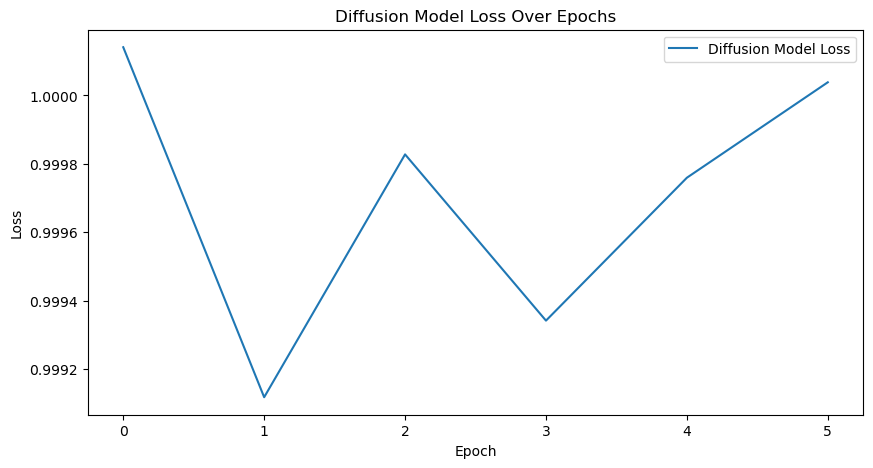

In [462]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

vae.eval()  # Set VAE to evaluation mode

# Initialize the Diffusion Scheduler
scheduler = DiffusionScheduler(timesteps=1000, device=device)

# Initialize the Diffusion U-Net
diffusion_model = DiffusionUNet(latent_channels=128, time_emb_dim=128, dropout=0.1).to(device)

# Combine into Latent Diffusion Model
ldm = LatentDiffusionModel(vae, diffusion_model, scheduler).to(device)

# Optimizer (only parameters of the diffusion model are trained)
optimizer = optim.Adam(ldm.diffusion_model.parameters(), lr=1e-4)

# Assume you have a dataset and DataLoader
# Replace `YourDataset` with your actual dataset class
# Example:
# from torchvision import datasets, transforms
# transform = transforms.Compose([transforms.ToTensor()])
# dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# For demonstration, let's assume `dataloader` is defined
# Example:
# dataloader = DataLoader(your_dataset, batch_size=32, shuffle=True)
# Training Loop with Early Stopping
num_epochs = 100
patience = 4
best_loss = float('inf')
patience_counter = 0
ldm.train()  # Set diffusion model to training mode
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_idx, batch in tqdm(enumerate(plaque_loader), total=len(plaque_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
        x = batch.to(device)  # Move data to device
        
        optimizer.zero_grad()
        loss = ldm(x)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(plaque_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")
    
    # Early Stopping Check
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        best_state = ldm.state_dict()
        print(f"  New best loss: {best_loss:.6f}")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model state
if best_state is not None:
    ldm.load_state_dict(best_state)
    print("Loaded the best model state based on validation loss.")
else:
    print("No improvement during training.")

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Diffusion Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Diffusion Model Loss Over Epochs')
plt.show()


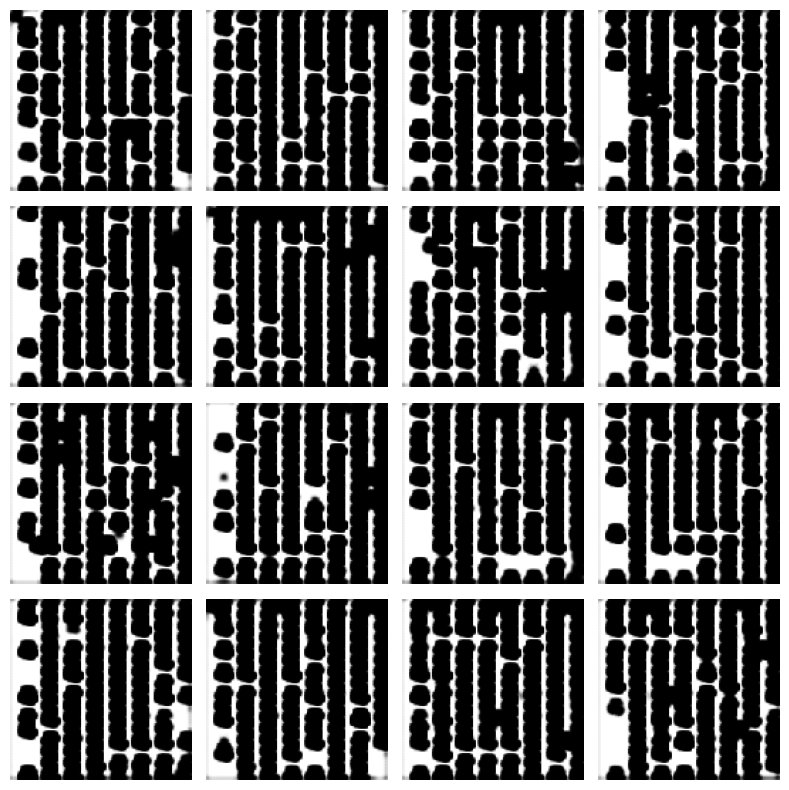

In [463]:
# Sampling New Images
def sample_ldm(ldm, num_samples, device, latent_shape):
    ldm.eval()  # Set model to evaluation mode
    with torch.no_grad():
        samples = ldm.sample(num_samples, device, latent_shape)
        return samples

# Parameters
num_samples = 16
latent_shape = (128, 8, 8)  # Adjust based on your VAE's latent space dimensions

# Generate Samples
samples = sample_ldm(ldm, num_samples, device, latent_shape)

# Visualization
samples = samples.cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    if i < num_samples:
        ax.imshow(samples[i, 0], cmap='gray')  # Assuming single-channel images
        ax.axis('off')
plt.tight_layout()
plt.show()